In [87]:
import os
import numpy as np
import pandas as pd
import featuretools as ft
import matplotlib.pyplot as plt
import hyperopt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", color_codes=True)
from scipy import stats
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

train = pd.read_csv("train.csv",parse_dates=["pickup_time","drop_time"])

In [86]:
train.head(5)

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,...,is_FairCorrect,diff,Year,Month,Date,Day of Week,Hour,H_Distance,Pick_cluster_label,Drop_cluster_label
0,189123628,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,...,1,0,2019,11,1,4,0,5.092770,0,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,...,1,0,2019,11,1,4,0,3.168058,0,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,...,1,0,2019,11,1,4,1,6.305395,0,0
3,189127273,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,...,1,0,2019,11,1,4,2,0.861946,0,0
4,189128020,NaN,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,...,1,0,2019,11,1,4,3,8.147782,0,0


In [70]:
print(train.isnull().sum())

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64


In [71]:
des1 = train.describe()
des2 = train.isnull().sum().to_frame(name = 'missing').T
pd.concat([des1, des2])

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time,drop_time,label
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000,NaN,NaN,NaN
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466,NaN,NaN,NaN
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565,NaN,NaN,NaN
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,NaN,NaN,NaN
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000,NaN,NaN,NaN
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000,NaN,NaN,NaN
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000,NaN,NaN,NaN
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,NaN,NaN,NaN
missing,0.000000e+00,202.000000,202.000000,202.000000,202.000000,202.000000,0.000000,0.000000,0.000000,0.000000,137.000000,0.0,0.0,0.0


In [88]:
train = train[train.drop_lat != 48.132000] # drop value error data entry
correctness_map = {'correct': 1, 'incorrect': 0}
train['is_FairCorrect']= train['label'].map(correctness_map) # tranform label string value into numeric value


# Generate new features from pickup time 
data = [train]
for i in data:
    i['diff'] = i['drop_time'].dt.day - i['pickup_time'].dt.day
    i['Year'] = i['pickup_time'].dt.year
    i['Month'] = i['pickup_time'].dt.month
    i['Date'] = i['pickup_time'].dt.day
    i['Day of Week'] = i['pickup_time'].dt.dayofweek
    i['Hour'] = i['pickup_time'].dt.hour
    
# Calculate trip distance     
def haversine_distance(lat1, long1, lat2, long2):
    data = [train]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d
haversine_distance('pick_lat', 'pick_lon', 'drop_lat', 'drop_lon')
train = train.drop(['label','pickup_time','drop_time'], axis = 1)

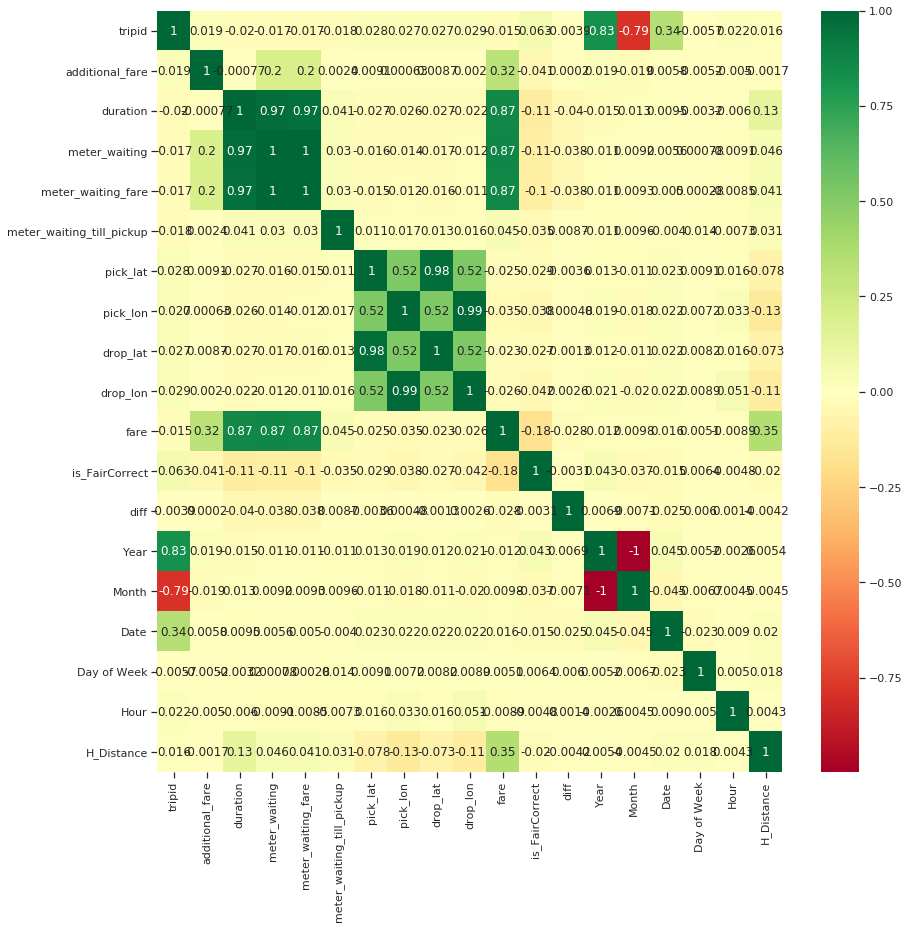

In [73]:
#plot heat map
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,14))
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

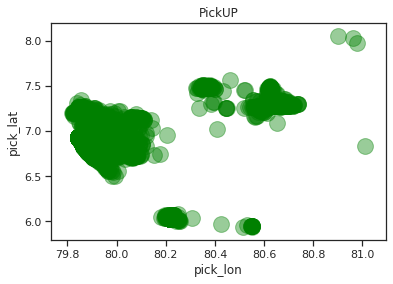

In [74]:
#Pick Up Location visualization
train.plot(kind='scatter', x='pick_lon', y='pick_lat',color='green', s=250, alpha=.4)
plt.title("PickUP")
plt.show(block=True);

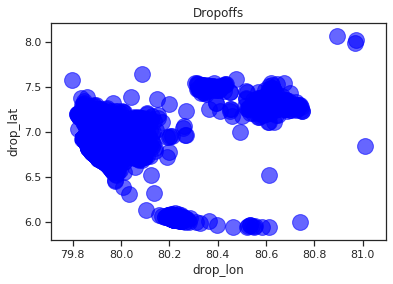

In [75]:
#Drop location visualization
train.plot(kind='scatter', x='drop_lon', y='drop_lat',color='blue',s=250, alpha=.6)
plt.title("Dropoffs")
plt.show(block=True);

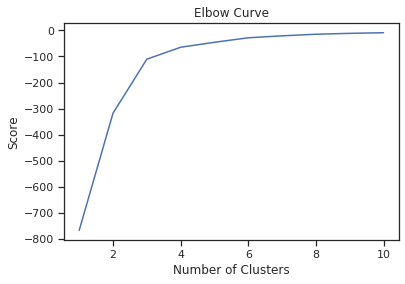

In [76]:
#Geolocation clustering with kmean algorithm
#use elbow curve to identify cluster count
K_clusters = range(1,11)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train[['drop_lat']]
X_axis = train[['drop_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

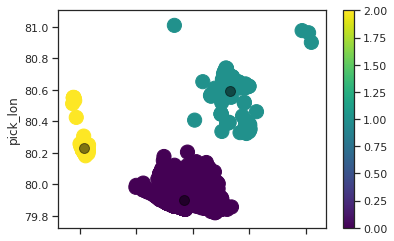

In [89]:
# pick up location clustering with KMEan
X=train.loc[:,['tripid','pick_lat','pick_lon']]
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['Pick_cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
#Visualize pick up clustering
X.plot.scatter(x = 'pick_lat', y = 'pick_lon', c=labels, s=200, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
X = X[['tripid','Pick_cluster_label']]
#X.head(5)
train=train.merge(X, left_on='tripid', right_on='tripid')



#drop location clustering with KMean
X=train.loc[:,['tripid','drop_lat','drop_lon']]
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['Drop_cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X = X[['tripid','Drop_cluster_label']]
#X.head(5)
train=train.merge(X, left_on='tripid', right_on='tripid')



41.02851431661326


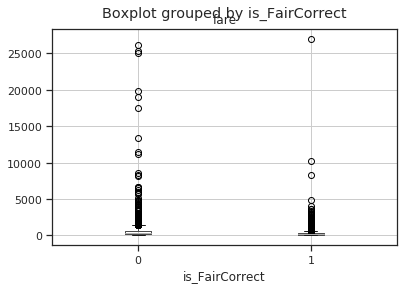

In [78]:
#Visualize Outliers
train.boxplot(column='fare', by='is_FairCorrect')
print(train['meter_waiting'].skew())

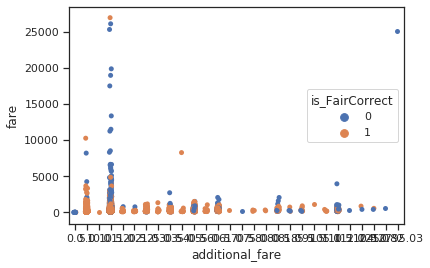

In [80]:
sns.stripplot(x="additional_fare", y="fare", hue="is_FairCorrect", data=train);


In [81]:
group_by_addfare = train.groupby([(train['fare']==0),'is_FairCorrect'])
group_by_addfare.size().unstack()

is_FairCorrect,0,1
fare,,
False,1724,15493
True,13,1


In [92]:

#generated ratio and proportion features
train['additional_fare + meter_waiting_fare' ] = train['additional_fare'] + train['meter_waiting_fare']
train['meter_waiting + meter_waiting_till_pickup'] = train['meter_waiting'] + train['meter_waiting_till_pickup']
train['duration - meter_waiting - meter_waiting_till_pickup'] = train['duration'] - train['meter_waiting'] - train['meter_waiting_till_pickup'] 
train['H_Distance/fare -(additional_fare+meter_waiting_fare)'] = train['H_Distance'] / ((train['fare'] - train['additional_fare'] - train['meter_waiting_fare'] ))
train['H_Distance/duration - meter_waiting - meter_waiting_till_pickup'] = train['H_Distance'] / ( train['duration'] - train['meter_waiting'] - train['meter_waiting_till_pickup'] )
train['additional_fare/H_Distance'] = train['additional_fare'] / train['H_Distance']
train['additional_fare/duration'] = train['additional_fare'] / train['duration']
train['additional_fare/fare'] = train['additional_fare'] / train['fare']
train['fare -(additional_fare+meter_waiting_fare)/fare'] =  (train['fare'] - train['additional_fare'] - train['meter_waiting_fare'] )/ train['fare']
train['fare/duration'] = train['fare'] / train['duration']
train['fare/additional_fare'] = train['fare'] / train['additional_fare']
train['fare/meter_waiting_fare'] = train['fare'] / train['meter_waiting_fare']
train['meter_waiting/duration'] = train['meter_waiting'] / train['duration']
train['meter_waiting_till_pickup/duration'] = train['meter_waiting_till_pickup'] / train['duration']
train['(meter_waiting+meter_waiting_till_pickup)/duration'] = (train['meter_waiting']+train['meter_waiting_till_pickup'])/ train['duration']
train['additional_fare+meter_waiting_fare/fare'] = (train['additional_fare']+train['meter_waiting_fare'])/train['fare']

#check for weekend and rush hours
train['is_weekend'] = train['Day of Week'].apply(lambda x: 1 if x in (5, 6) else 0)
train['is_rush_hour'] = train['Hour'].apply(lambda x: 0 if x in (0, 1,2,3,4,5, 6,7,22,23) else 1)

In [ ]:
#---------------------------------------------------------------------KNN imputation
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=20)
#x_imputed = imputer.fit_transform(x_train)
#x_train = pd.DataFrame(x_imputed, columns = x_train.columns) ##adding column names
train["meter_waiting_fare"] = imputer.fit_transform(train[["meter_waiting_fare"]])

#----------------------------------------------------------------------IterativeImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=100, random_state=0)
#x_imputed = imp.fit_transform(x_train)
#x_train = pd.DataFrame(x_imputed, columns = x_train.columns) ##adding column names
train["fare"] = imp.fit_transform(train[["fare"]])

#---------------------------------------------------------------------Other imputation method
# replace missing values with the column mean,median or with 0
train=train.fillna(train.mean())
train=train.fillna(train.median())
train = train.fillna(0)


In [ ]:
#----------------------------------------------------Equal-Width/frequency/Kmean/quantile Discretization
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisers import EqualWidthDiscretiser

#discretizer = EqualWidthDiscretiser(bins=200, variables = ['H_Distance', 'additional_fare','duration'])
#OR
#discretizer = KBinsDiscretizer(n_bins=200, encode='ordinal', strategy='quantile')
x_train = discretizer.fit_transform(x_train)
discretizer.transform(X_test[["additional_fare"]])
x_train = pd.DataFrame(x_imputed, columns = x_train.columns)


#--------------------------------------------------------------DecisionTree Discretiser 

treeDisc = DecisionTreeDiscretiser(cv=10, scoring='f1_macro',
                                   variables=['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',],
                                   regression=False,
                                   param_grid={'max_depth': [3,10,20,200],
'min_samples_leaf':[10,4]})
x_train = treeDisc.fit_transform(x_train,y)
treeDisc.transform(X_test)

In [ ]:
#----------------------------------------------oversampling using SMOTE and ADASYN
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN

sm = SMOTE(random_state = 2) 
x_train, y = sm.fit_sample(x_train, y.ravel()) 
x_train, y = ADASYN().fit_sample(x_train, y) 


#-----------------------------------------------------------------Ensemble samplers

from imblearn.ensemble import EasyEnsemble
e = EasyEnsemble(random_state=0, n_subsets=10)
e.fit(x_train, y)
x_train, y = e.sample(x_train, y)


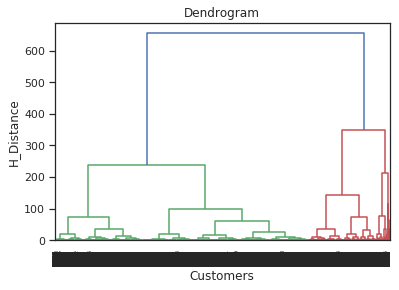

In [85]:

#use a dendrogram to visualize the optimal number of clusters
X=train[['H_Distance']]
import scipy.cluster.hierarchy as sch
dendrogrm = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('H_Distance')
plt.show()

In [ ]:
#----------------------------------------------------------------------------Hierachical Clustering
from sklearn.cluster import AgglomerativeClustering

X=train[['H_Distance']]
model = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
model.fit(X)

#---------------------------------------------------------------------------Density-Based Clustering 
from sklearn.cluster import DBSCAN
#X=x_train[['pick_lat','pick_lon']]
p = DBSCAN(eps=10, min_samples=10).fit(x_train[['H_Distance',]])
labels=p.labels_
x_train["H_Distance_cluster"]=labels
set(clustering.labels_)



In [106]:
from sklearn.model_selection import train_test_split


x_train = train.iloc[:,train.columns!='is_FairCorrect']
y = train['is_FairCorrect'].values
x_train =x_train.drop(['tripid'], axis = 1)
x_train, X_test, y, y_test = train_test_split(x_train, y, test_size=0.3, random_state=22)
x_train = x_train.fillna(0)
X_test = X_test.fillna(0)

In [ ]:
X_train=x_train
y_train=y

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

print("########################################################------------Decision Tree model")
clf = DecisionTreeClassifier()
clf.fit(x_train, y)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
print('sklearn Macro-F1-Score:', f1_score(y_test, y_pred, average='macro'))
print("########################################################------------Random Forest model")
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
print('sklearn Macro-F1-Score:', f1_score(y_test, y_pred, average='macro'))
print("########################################################----------AdaBoost model")
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
print('sklearn Macro-F1-Score:', f1_score(y_test, y_pred, average='macro'))
print("########################################################-------------Gradient Boosting model")
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
print('sklearn Macro-F1-Score:', f1_score(y_test, y_pred, average='macro'))
print("########################################################------------XGBoosting model")
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()
print('sklearn Macro-F1-Score:', f1_score(y_test, y_pred, average='macro'))

print("########################################################------------Light GBM model")
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y)
params = {}
clf = lgb.train(params, d_train, 1000)
y_pred=clf.predict(X_test)
x=len(y_pred)
for i in range(0,x):
    if y_pred[i]>=.62:       
       y_pred[i]=int(1)
    else:  
       y_pred[i]=int(0)
    
report = classification_report(y_test, y_pred)
print(report)
print('sklearn Macro-F1-Score lightgbm:', f1_score(y_test, y_pred, average='macro'))

print("########################################################------------CatBoost model")
from catboost import CatBoostClassifier
clf = CatBoostClassifier(logging_level='Silent')

clf.fit(x_train,y)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
print('sklearn Macro-F1-Score:', f1_score(y_test, y_pred, average='macro'))
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(27).plot(kind='barh')
plt.show()


In [ ]:
#-----------------------------------------------------Hyper parameter tuning with RandomizedSearch

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=600, objective='binary:logistic',
                    silent=True)
param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'gamma': np.arange(0.0,40.0,0.005),
        'learning_rate': np.arange(0.005,0.3,0.05),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01)}
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
grid_search = RandomizedSearchCV(model, param_grid,  n_jobs=4, scoring='f1_macro', n_iter = 500, cv=kfold)
grid_result = grid_search.fit(x_train,y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#-------------------------------------------------------------Bayesian optimization with hyperopt
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,pyll
space = {
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 10,180,1),

        'max_depth':pyll.scope.int(hyperopt.hp.quniform('max_depth', 2, 10, 1)),

        'n_estimators':hp.choice('n_estimators', np.arange(1000, 10000, 10, dtype=int)),

        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),

        'min_child_weight':hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),

        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),

        'eta':hp.quniform('eta', 0.01, 0.3, 0.05),
        'scale_pos_weight': 0.1 }

def hyperparameter_tuning(space):
    clf=xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],subsample =space['subsample'],eta =space['eta'],scale_pos_weight=0.1)
    evaluation = [( x_train, y),( X_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="error",
            early_stopping_rounds=20,verbose=False)

    pred = clf.predict(X_test)
    accuracy = f1_score(y_test, pred, average='macro')
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

def optimize(trials, space):
    best = fmin(hyperparameter_tuning, space, algo=tpe.suggest, max_evals=400)
    return best

trials = Trials()

best_params = optimize(trials, space)

In [114]:
#----------------------------------------------------------Max Voting Ensemble Technique
import statistics
model1 = xgb.XGBClassifier(ccp_alpha=0.0,
criterion='friedman_mse',scale_pos_weight=0.8,min_child_weight=10,gamma=1,colsample_bytree=1.0,early_stopping_rounds=15,

                                                        init=None,
                                                        learning_rate=0.01,
                                                        loss='deviance',
                                                        max_depth=4,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=500,
                                                        subsample=1,
                                                        tol=0.0001,
                                                        validation_fraction=0.1,
                                                        verbose=0,
                                                        warm_start=False)
model2 = clf = xgb.XGBClassifier(ccp_alpha=0.0,learning_rate= 0.1705,
criterion='friedman_mse',scale_pos_weight=0.33,min_child_weight=0.2881,gamma=4.58,colsample_bytree=0.8799999999999996,subsample=0.79,

                                                        init=None,
                                                        #learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=7,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=500,
                                                        #subsample=0.8,
                                                        tol=0.0001,
                                                        validation_fraction=0.1,
                                                        verbose=0,colsample_bylevel=1.0,
                                                        warm_start=False)
model3= CatBoostClassifier(logging_level='Silent')

model1.fit(x_train,y)
model2.fit(x_train,y)
model3.fit(x_train,y)

pred1=model1.predict(X_test)
pred2=model2.predict(X_test)
pred3=model3.predict(X_test)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred,statistics.mode([pred1[i],pred2[i], pred3[i]]))
    
print('sklearn Macro-F1-Score:', f1_score(y_test, final_pred, average='macro'))

sklearn Macro-F1-Score: 0.8646141649048626


In [108]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y)
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] =  33
params['min_data'] = 72
params['max_depth'] = 10
params['max_bin'] = 100
params['colsample_bytree'] = 0.7492576308443197
params['min_child_samples'] = 201
params['min_child_weight'] =  1
params['reg_alpha'] = 1
params['subsample'] = 0.9800098255364353
params['reg_lambda'] = 0.1



#colsample_bytree': 0.8868789411693111, 'min_child_samples': 171, 'min_child_weight': 0.001, 
#'num_leaves': 27, 'reg_alpha': 5, 'reg_lambda': 10, 'subsample': 0.8539213200303521

clf = lgb.train(params, d_train, 1000)

y_pred1=clf.predict(X_test)
x=len(y_pred)
for i in range(0,x):
    if y_pred[i]>=.63:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0
    

In [109]:
clf = xgb.XGBClassifier(ccp_alpha=0.0,
criterion='friedman_mse',scale_pos_weight=0.8,min_child_weight=10,gamma=1,colsample_bytree=1.0,early_stopping_rounds=15,

                                                        init=None,
                                                        learning_rate=0.01,
                                                        loss='deviance',
                                                        max_depth=4,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=500,
                                                        subsample=1,
                                                        tol=0.0001,
                                                        validation_fraction=0.1,
                                                        verbose=0,
                                                        warm_start=False)
#clf.fit(X_train, y_train)
clf.fit(x_train,y)
y_pred2 = clf.predict(X_test)